In [1]:
import pandas as pd
import numpy as np
import os

In [63]:
list_instances = ['3506', '3565', '3642', '3650', '3693', '3705', '3706', '3738', '3745', '3822', '3832',
                '3838', '3850', '3852', '3877', '5721', '5725', '5755', '5875', '5881', '5882', '5909', '5922']
list_solver = ['DTSS','MSTS','SA']

# Clean the log output from HPC

In [62]:
for i in range(len(list_solver)):
    for j in range(len(list_instances)):
        col_names = ['solver', 'instance', 'counter', 'iteration', 'local best', 'current best', 'time']
        col_names_2 = ['instance', 'size', 'density', 'obj value', 'time', 'opt obj value', 'opt obj value from file']
        df = pd.DataFrame(columns = col_names)
        df_2 = pd.DataFrame(columns = col_names_2)

        name = ""

        counter_dir = {}
        output_path = "./log_{}/QPLIB_{}/output.file".format(list_solver[i], list_instances[j])
                
        with open(output_path, 'r') as file:
            for idx, line in enumerate(file):
                if ".qs" in line.rstrip() and len(line.rstrip().split(" ")) == 2:
                    name = line.rstrip()
                    if line.rstrip() in counter_dir.keys():
                        counter_dir[line.rstrip()] += 1

                    else:
                        counter_dir[line.rstrip()] = 1

                if "Iteration" in line.rstrip():
                    solver = name.split(' ')[0]
                    instance = name.split(' ')[1]
                    counter = counter_dir[name]
                    iteration = line.rstrip().split(';')[0].split(" ")[-1]
                    local_best = line.rstrip().split(';')[1].split(" ")[-1]
                    current_best = line.rstrip().split(';')[2].split(" ")[-1]
                    time = line.rstrip().split(';')[3].split(" ")[-1]

                    value = [solver, instance, counter, iteration, local_best, current_best, time]
                    df.loc[len(df)] = value

                if ".qs" in line.rstrip() and len(line.rstrip().split(" ")) == 7:
                    df_2.loc[len(df_2)] = line.rstrip().split(" ")

        df_2['gap'] = df_2['opt obj value'].astype(int) - df_2['obj value'].astype(int)
        df_2['gap %'] = df_2['gap'] / df_2['opt obj value'].astype(int) * 100

        df['time'] = df['time'].astype(float)
        df['cumtime'] = df.groupby('counter')['time'].cumsum()
        df['iteration'] = df['iteration'].astype(int)
        df['counter'] = df['counter'].astype(int)
        df['local best'] = df['local best'].astype(float)
        df['current best'] = df['current best'].astype(float)
        df['opt obj value'] = np.ones(len(df)) * float(df_2['opt obj value'][0])
        df_2['counter'] = np.arange(1,len(df_2)+1)
        df_2 = pd.merge(df_2,
                df.loc[df['current best'] == df['opt obj value']].groupby('counter').min()[['cumtime']],
                on = 'counter',
                how = 'outer')
        df_2.rename(columns={"cumtime": "time opt"})

        filename_log = "./log_{}/QPLIB_{}/table_log.csv".format(list_solver[i], list_instances[j])
        filename_result = "./log_{}/QPLIB_{}/table_result.csv".format(list_solver[i], list_instances[j])
        df.to_csv(filename_log, sep=";")
        df_2.to_csv(filename_result, sep=';')

# We found a new best solution for "QPLIB_3693"
# Therefore, we have to update the table
for algo_name in ["DTSS", "MSTS", "SA"]:
    temp = pd.read_csv("./log_"+algo_name+"/QPLIB_3693/table_result.csv", header=0, sep=";")
    temp.loc[:, "gap"] = temp.loc[:, "gap"] + 2
    temp.loc[:, "opt obj value"] = temp.loc[:, "opt obj value"] + 2
    temp.loc[:, "opt obj value from file"] = temp.loc[:, "opt obj value from file"] + 2
    temp.loc[:, "gap %"] = temp.loc[:, "gap %"] / 1150 * 100
    temp.to_csv("./log_"+algo_name+"/QPLIB_3693/table_result.csv", sep=";")

./log_DTSS/QPLIB_3693/output.file
./log_MSTS/QPLIB_3693/output.file
./log_SA/QPLIB_3693/output.file


## table example

In [66]:
pd.read_csv("./log_DTSS/QPLIB_3506/table_log.csv", index_col=0, sep=';')

,solver,instance,counter,iteration,local best,current best,time,cum time,opt obj value
0,DTSS,QPLIB_3506.qs,1,1,430.0,430.0,0.389442,0.389442,478.0
1,DTSS,QPLIB_3506.qs,1,2,430.0,430.0,0.360107,0.749549,478.0
2,DTSS,QPLIB_3506.qs,1,3,432.0,432.0,0.399237,1.148786,478.0
3,DTSS,QPLIB_3506.qs,1,4,446.0,446.0,0.383259,1.532045,478.0
4,DTSS,QPLIB_3506.qs,1,5,452.0,452.0,0.524324,2.056369,478.0
...,...,...,...,...,...,...,...,...,...
18908,DTSS,QPLIB_3506.qs,100,120,476.0,478.0,0.441692,56.360935,478.0
18909,DTSS,QPLIB_3506.qs,100,121,470.0,478.0,0.440143,56.801078,478.0
18910,DTSS,QPLIB_3506.qs,100,122,474.0,478.0,0.838143,57.639221,478.0
18911,DTSS,QPLIB_3506.qs,100,123,474.0,478.0,0.439084,58.078305,478.0


In [67]:
pd.read_csv("./log_DTSS/QPLIB_3506/table_result.csv", index_col=0, sep=';')

,instance,size,density,obj value,time,opt obj value,opt obj value from file,gap,gap %,counter,cum time
0,QPLIB_3506.qs,496,0.005227,472,67.34s,478,478,6,1.25523,1,NaN
1,QPLIB_3506.qs,496,0.005227,474,57.98s,478,478,4,0.83682,2,NaN
2,QPLIB_3506.qs,496,0.005227,478,91.79s,478,478,0,0.00000,3,42.945294
3,QPLIB_3506.qs,496,0.005227,476,67.99s,478,478,2,0.41841,4,NaN
4,QPLIB_3506.qs,496,0.005227,478,72.67s,478,478,0,0.00000,5,25.407000
...,...,...,...,...,...,...,...,...,...,...,...
95,QPLIB_3506.qs,496,0.005227,478,157.90s,478,478,0,0.00000,96,112.986047
96,QPLIB_3506.qs,496,0.005227,476,103.67s,478,478,2,0.41841,97,NaN
97,QPLIB_3506.qs,496,0.005227,476,101.51s,478,478,2,0.41841,98,NaN
98,QPLIB_3506.qs,496,0.005227,476,72.33s,478,478,2,0.41841,99,NaN


# Average Gap to Actual Optimum in Percent and Optimum Hit Count Table

In [65]:
average_gap_pct = {}
hit_count = {}

instance_names = []

for algo_name in list_solver:
    average_gap_pct[algo_name] = {}
    hit_count[algo_name] = {}
    for i in list_instances:
        folder = "QPLIB_" + i 
        results = pd.read_csv("./log_"+algo_name+"/"+folder+"/table_result.csv", header=0, sep=";")
        average_gap_pct[algo_name][folder] = results.loc[:, "gap %"].mean()
        instanceHitCount = (results.loc[:, "gap"] == 0)
        hit_count[algo_name][folder] = instanceHitCount.sum()

        if folder not in instance_names:
            instance_names.append(folder)

hit_count = pd.DataFrame.from_dict(hit_count)
hit_count.to_csv("./Hit_count_table.csv", sep=";")
print(hit_count)
average_gap_pct = pd.DataFrame.from_dict(average_gap_pct)
average_gap_pct.to_csv("./Average_gap_pct_table.csv", sep=";")
print(average_gap_pct)

            DTSS  MSTS  SA
QPLIB_3506    14     1  15
QPLIB_3565    39    95   7
QPLIB_3642     0     0   0
QPLIB_3650     0     0   2
QPLIB_3693     0     0   1
QPLIB_3705    24    82  16
QPLIB_3706     1     0   2
QPLIB_3738     2     1   5
QPLIB_3745    95   100  40
QPLIB_3822     0     0   2
QPLIB_3832     2     0   3
QPLIB_3838     0     0   0
QPLIB_3850     0     0   1
QPLIB_3852   100   100  93
QPLIB_3877     3     0   2
QPLIB_5721     0     0   0
QPLIB_5725    34     6   0
QPLIB_5755     0     0   0
QPLIB_5875   100   100   4
QPLIB_5881   100   100   1
QPLIB_5882   100   100   5
QPLIB_5909   100   100   0
QPLIB_5922   100   100   0
                DTSS      MSTS         SA
QPLIB_3506  0.661088  1.246862   0.711297
QPLIB_3565  0.460993  0.035461   0.907801
QPLIB_3642  2.854932  7.624758   1.112186
QPLIB_3650  2.008696  6.360870   0.836957
QPLIB_3693  0.198455  0.627026   0.064839
QPLIB_3705  0.640625  0.093750   0.864583
QPLIB_3706  1.739003  4.612903   1.038123
QPLIB_3738  0.91

# Percentage of Total Runs ($100$ Runs Times $23$ Instances) per Algorithm which Achieve An Objective Value Less or Equal to $n$ Times The Second Lowest Gap in Absolute Term to The Actual Optimal Objective Value.

In [37]:
run_obj_val_over_best_instance_obj_val = {"DDTS": [],
                                          "MSTS": [],
                                          "SA": []
                                          }

for instance in instance_names:
    dtss_results = pd.read_csv("./log_DTSS/"+instance+"/table_result.csv", header=0, sep=";").loc[:, "gap"].to_numpy()
    dtss_min_nonzero_gaps = dtss_results[np.nonzero(dtss_results)]
    
    msts_results = pd.read_csv("./log_MSTS/"+instance+"/table_result.csv", header=0, sep=";").loc[:, "gap"].to_numpy()
    msts_min_nonzero_gaps = msts_results[np.nonzero(msts_results)]

    sa_results = pd.read_csv("./log_SA/"+instance+"/table_result.csv", header=0, sep=";").loc[:, "gap"].to_numpy()
    sa_min_nonzero_gaps = sa_results[np.nonzero(sa_results)]

    second_best_gap = np.concatenate([dtss_min_nonzero_gaps, msts_min_nonzero_gaps, sa_min_nonzero_gaps])
    second_best_gap = np.amin(second_best_gap)
    #print(instance, second_best_gap)
    run_obj_val_over_best_instance_obj_val["DDTS"].append((dtss_results - second_best_gap) / second_best_gap)
    run_obj_val_over_best_instance_obj_val["MSTS"].append((msts_results - second_best_gap) / second_best_gap)
    run_obj_val_over_best_instance_obj_val["SA"].append((sa_results - second_best_gap) / second_best_gap)

run_obj_val_over_best_instance_obj_val["DDTS"] = np.concatenate(run_obj_val_over_best_instance_obj_val["DDTS"])
print(np.max(run_obj_val_over_best_instance_obj_val["DDTS"]))
run_obj_val_over_best_instance_obj_val["MSTS"] = np.concatenate(run_obj_val_over_best_instance_obj_val["MSTS"])
print(np.max(run_obj_val_over_best_instance_obj_val["MSTS"]))
run_obj_val_over_best_instance_obj_val["SA"] = np.concatenate(run_obj_val_over_best_instance_obj_val["SA"])
print(np.max(run_obj_val_over_best_instance_obj_val["SA"]))

26.0
62.0
218.81425324395087


In [38]:
xAxisPointCount = 21

cummulative_distribution = {"DDTS": [],
                            "MSTS": [],
                            "SA": []
                            }

for i in range(xAxisPointCount):
    cummulative_distribution["DDTS"].append(np.sum((run_obj_val_over_best_instance_obj_val["DDTS"] <= i)) / len(run_obj_val_over_best_instance_obj_val["DDTS"]))
    cummulative_distribution["MSTS"].append(np.sum((run_obj_val_over_best_instance_obj_val["MSTS"] <= i)) / len(run_obj_val_over_best_instance_obj_val["MSTS"]))
    cummulative_distribution["SA"].append(np.sum((run_obj_val_over_best_instance_obj_val["SA"] <= i)) / len(run_obj_val_over_best_instance_obj_val["SA"]))

cummulative_distribution = pd.DataFrame.from_dict(cummulative_distribution)
print(cummulative_distribution)

        DDTS      MSTS        SA
0   0.450000  0.416522  0.220870
1   0.553913  0.490435  0.348696
2   0.641304  0.533913  0.458261
3   0.688696  0.586087  0.537826
4   0.708261  0.607826  0.621739
5   0.736087  0.623478  0.686957
6   0.760000  0.640870  0.740870
7   0.784348  0.656957  0.777826
8   0.807826  0.668261  0.793478
9   0.828261  0.680870  0.800870
10  0.854348  0.690000  0.805217
11  0.878261  0.695652  0.809130
12  0.900870  0.700000  0.813043
13  0.923043  0.706087  0.819130
14  0.944783  0.714783  0.828261
15  0.959130  0.725652  0.839130
16  0.968696  0.733478  0.849565
17  0.974348  0.740000  0.860000
18  0.984348  0.751304  0.868696
19  0.988696  0.759565  0.873478
20  0.993478  0.769130  0.876522


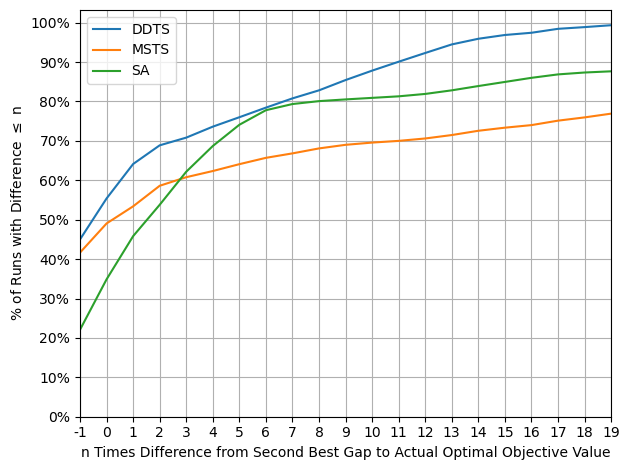

In [39]:
import matplotlib.pyplot as plt

axes = cummulative_distribution.plot()
axes.set_xticks([i for i in range(xAxisPointCount)], [str(i-1) for i in range(xAxisPointCount)])
axes.set_xlabel("n Times Difference from Second Best Gap to Actual Optimal Objective Value")
axes.set_yticks([i/10 for i in range(11)], [str(i*10)+"%" for i in range(11)])
axes.set_ylabel(r"% of Runs with Difference $\leq$ n")

fig = axes.get_figure()
plt.xlim(xmin=0, xmax=20)
plt.grid(True)
plt.tight_layout()
fig.savefig("./Performance_profile.png")